In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f9d94264-adb1-41c2-98f6-dcb0b4a8681c)


In [ ]:
!nvidia-smi

Tue Jun 29 23:49:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pip install -q tf-models-official

In [ ]:
pip install -q -U tensorflow-text

In [ ]:
#cargamos BERT
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [ ]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization 

import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
#lectura data
os.chdir("/content/drive/MyDrive/TAC Notebooks/TA Final")

In [ ]:
df = pd.read_csv("archive/fin-sent-dataset-1.csv",header=None, encoding = "ISO-8859-1")

In [ ]:
df.columns = ["sentiment","body"]

In [ ]:
df.shape

(4846, 2)

In [ ]:
df.head()

,sentiment,body
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [ ]:
df.sentiment.value_counts() / df.shape[0] * 100

neutral     59.409823
positive    28.126290
negative    12.463888
Name: sentiment, dtype: float64

neutral     59.409823
positive    28.126290
negative    12.463888
Name: sentiment, dtype: float64

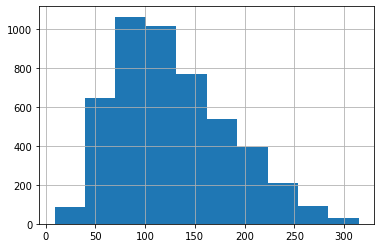

In [ ]:
df.body.apply(len).hist()

In [ ]:
#llamada a bert
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

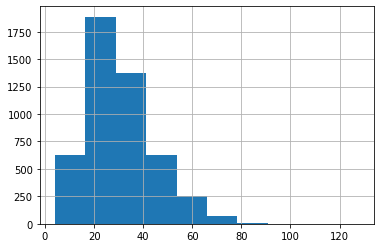

In [ ]:
token_counts = pd.Series(np.sum(bert_preprocess_model(df.body.values)["input_mask"],axis=1))
token_counts.hist()

In [ ]:
token_counts.describe()

count    4846.000000
mean       30.604210
std        13.576469
min         4.000000
25%        21.000000
50%        28.000000
75%        38.000000
max       128.000000
dtype: float64

In [ ]:
pd.get_dummies(df.sentiment)

,negative,neutral,positive
0,0,1,0
1,0,1,0
2,1,0,0
3,0,0,1
4,0,0,1
...,...,...,...
4841,1,0,0
4842,0,1,0
4843,1,0,0
4844,1,0,0


In [ ]:
#Split en train, val y set
from sklearn.model_selection import train_test_split
X = df.body.values
y = pd.get_dummies(df.sentiment).values
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split( X_test, y_test, test_size=0.5, random_state=0)

In [ ]:
y_train.shape, X_train.shape

((3392, 3), (3392,))

In [ ]:
#cargamos BERT y definimos tokenizers

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(3, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
model = build_classifier_model()

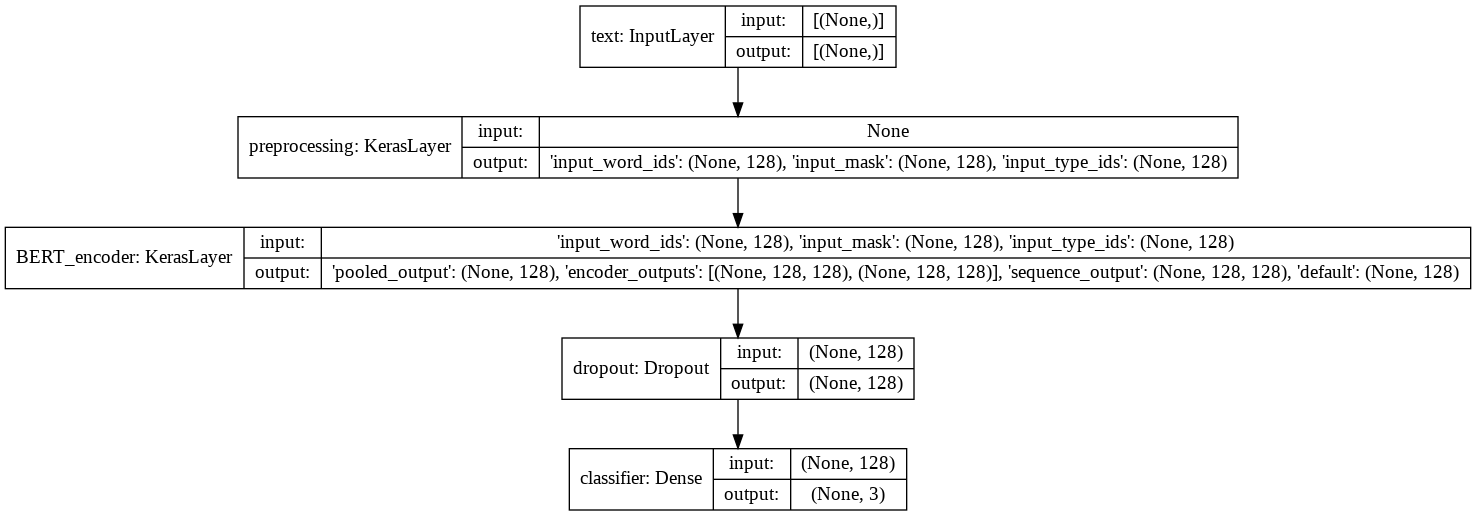

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
#hiperparametros BERT
epochs = 50
steps_per_epoch = X_train.shape[0]
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy',tf.keras.metrics.AUC(name="auc"),]
)

In [ ]:
model.save('sent-model')

INFO:tensorflow:Assets written to: sent-model/assets


INFO:tensorflow:Assets written to: sent-model/assets


In [ ]:
#guardamos mejor entrenamiento
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('sent-model',save_best_only=True,verbose=1,monitor='val_auc',mode="max")
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', min_delta=0.01, patience=5, verbose=0, mode='max', baseline=None, restore_best_weights=False )

In [ ]:
history = model.fit(
    X_train,
    y_train,
    batch_size = 5,
    epochs=epochs,
    callbacks=[model_checkpoint_callback,es_callback],
    validation_data=(X_val,y_val)
)

Epoch 1/50
679/679 [==============================] - 29s 39ms/step - loss: 0.9191 - accuracy: 0.5781 - auc: 0.7588 - val_loss: 0.8494 - val_accuracy: 0.6355 - val_auc: 0.7952

Epoch 00001: val_auc improved from -inf to 0.79517, saving model to sent-model


INFO:tensorflow:Assets written to: sent-model/assets


INFO:tensorflow:Assets written to: sent-model/assets


Epoch 2/50
679/679 [==============================] - 26s 38ms/step - loss: 0.8682 - accuracy: 0.6011 - auc: 0.7866 - val_loss: 0.8151 - val_accuracy: 0.6465 - val_auc: 0.8152

Epoch 00002: val_auc improved from 0.79517 to 0.81518, saving model to sent-model


INFO:tensorflow:Assets written to: sent-model/assets


INFO:tensorflow:Assets written to: sent-model/assets


Epoch 3/50
679/679 [==============================] - 26s 39ms/step - loss: 0.8339 - accuracy: 0.6221 - auc: 0.8051 - val_loss: 0.8058 - val_accuracy: 0.6671 - val_auc: 0.8253

Epoch 00003: val_auc improved from 0.81518 to 0.82528, saving model to sent-model


INFO:tensorflow:Assets written to: sent-model/assets


INFO:tensorflow:Assets written to: sent-model/assets


Epoch 4/50
679/679 [==============================] - 26s 38ms/step - loss: 0.8000 - accuracy: 0.6356 - auc: 0.8217 - val_loss: 0.7795 - val_accuracy: 0.6685 - val_auc: 0.8376

Epoch 00004: val_auc improved from 0.82528 to 0.83760, saving model to sent-model


INFO:tensorflow:Assets written to: sent-model/assets


INFO:tensorflow:Assets written to: sent-model/assets


Epoch 5/50
679/679 [==============================] - 26s 38ms/step - loss: 0.7527 - accuracy: 0.6636 - auc: 0.8436 - val_loss: 0.7535 - val_accuracy: 0.6699 - val_auc: 0.8470

Epoch 00005: val_auc improved from 0.83760 to 0.84704, saving model to sent-model


INFO:tensorflow:Assets written to: sent-model/assets


INFO:tensorflow:Assets written to: sent-model/assets


Epoch 6/50
679/679 [==============================] - 26s 39ms/step - loss: 0.7070 - accuracy: 0.6937 - auc: 0.8627 - val_loss: 0.7425 - val_accuracy: 0.6878 - val_auc: 0.8579

Epoch 00006: val_auc improved from 0.84704 to 0.85793, saving model to sent-model


INFO:tensorflow:Assets written to: sent-model/assets


INFO:tensorflow:Assets written to: sent-model/assets


Epoch 7/50
679/679 [==============================] - 26s 38ms/step - loss: 0.6571 - accuracy: 0.7099 - auc: 0.8812 - val_loss: 0.7114 - val_accuracy: 0.6946 - val_auc: 0.8692

Epoch 00007: val_auc improved from 0.85793 to 0.86919, saving model to sent-model


INFO:tensorflow:Assets written to: sent-model/assets


INFO:tensorflow:Assets written to: sent-model/assets


Epoch 8/50
679/679 [==============================] - 26s 39ms/step - loss: 0.6057 - accuracy: 0.7482 - auc: 0.8999 - val_loss: 0.7325 - val_accuracy: 0.7180 - val_auc: 0.8748

Epoch 00008: val_auc improved from 0.86919 to 0.87484, saving model to sent-model


INFO:tensorflow:Assets written to: sent-model/assets


INFO:tensorflow:Assets written to: sent-model/assets


Epoch 9/50
679/679 [==============================] - 26s 39ms/step - loss: 0.5458 - accuracy: 0.7751 - auc: 0.9190 - val_loss: 0.6584 - val_accuracy: 0.7276 - val_auc: 0.8921

Epoch 00009: val_auc improved from 0.87484 to 0.89207, saving model to sent-model


INFO:tensorflow:Assets written to: sent-model/assets


INFO:tensorflow:Assets written to: sent-model/assets


Epoch 10/50
679/679 [==============================] - 26s 38ms/step - loss: 0.4900 - accuracy: 0.8025 - auc: 0.9353 - val_loss: 0.6733 - val_accuracy: 0.7414 - val_auc: 0.9005

Epoch 00010: val_auc improved from 0.89207 to 0.90047, saving model to sent-model


INFO:tensorflow:Assets written to: sent-model/assets


INFO:tensorflow:Assets written to: sent-model/assets


Epoch 11/50
679/679 [==============================] - 26s 39ms/step - loss: 0.4568 - accuracy: 0.8272 - auc: 0.9451 - val_loss: 0.6774 - val_accuracy: 0.7552 - val_auc: 0.9074

Epoch 00011: val_auc improved from 0.90047 to 0.90741, saving model to sent-model


INFO:tensorflow:Assets written to: sent-model/assets


INFO:tensorflow:Assets written to: sent-model/assets


Epoch 12/50
679/679 [==============================] - 27s 39ms/step - loss: 0.4178 - accuracy: 0.8491 - auc: 0.9547 - val_loss: 0.7108 - val_accuracy: 0.7469 - val_auc: 0.9078

Epoch 00012: val_auc improved from 0.90741 to 0.90782, saving model to sent-model


INFO:tensorflow:Assets written to: sent-model/assets


INFO:tensorflow:Assets written to: sent-model/assets


Epoch 13/50
679/679 [==============================] - 26s 39ms/step - loss: 0.4031 - accuracy: 0.8600 - auc: 0.9603 - val_loss: 0.7388 - val_accuracy: 0.7689 - val_auc: 0.9090

Epoch 00013: val_auc improved from 0.90782 to 0.90903, saving model to sent-model


INFO:tensorflow:Assets written to: sent-model/assets


INFO:tensorflow:Assets written to: sent-model/assets


Epoch 14/50
679/679 [==============================] - 26s 39ms/step - loss: 0.3890 - accuracy: 0.8644 - auc: 0.9646 - val_loss: 0.8098 - val_accuracy: 0.7675 - val_auc: 0.9085

Epoch 00014: val_auc did not improve from 0.90903
Epoch 15/50
679/679 [==============================] - 26s 38ms/step - loss: 0.3373 - accuracy: 0.8900 - auc: 0.9726 - val_loss: 0.9601 - val_accuracy: 0.7689 - val_auc: 0.9052

Epoch 00015: val_auc did not improve from 0.90903
Epoch 16/50
679/679 [==============================] - 26s 38ms/step - loss: 0.3316 - accuracy: 0.8918 - auc: 0.9751 - val_loss: 0.9123 - val_accuracy: 0.7772 - val_auc: 0.9087

Epoch 00016: val_auc did not improve from 0.90903
Epoch 17/50
679/679 [==============================] - 26s 38ms/step - loss: 0.3073 - accuracy: 0.9086 - auc: 0.9776 - val_loss: 1.0222 - val_accuracy: 0.7648 - val_auc: 0.8983

Epoch 00017: val_auc did not improve from 0.90903
Epoch 18/50
679/679 [==============================] - 26s 38ms/step - loss: 0.2686 - ac

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])

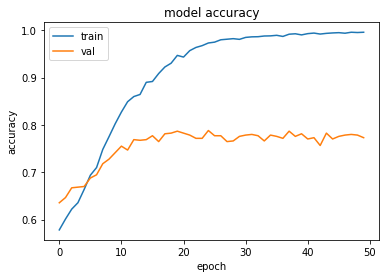

In [ ]:
from matplotlib import pyplot as plt
def plot_lines(history,train_key,val_key,title,y_tag):
  plt.plot(history.history[train_key])
  plt.plot(history.history[val_key])
  plt.title(title)
  plt.ylabel(y_tag)
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

plot_lines(history,'accuracy','val_accuracy','model accuracy','accuracy')

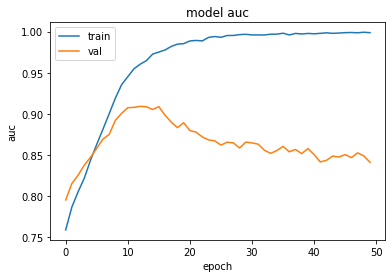

In [ ]:
plot_lines(history,'auc','val_auc','model auc','auc')

In [ ]:
evals = model.evaluate(X_test, y_test)

23/23 [==============================] - 2s 93ms/step - loss: 2.6499 - accuracy: 0.7607 - auc: 0.8385


In [ ]:
model.load_weights('sent-model')

In [ ]:
model.evaluate(X_test, y_test)

23/23 [==============================] - 2s 91ms/step - loss: 0.7614 - accuracy: 0.7730 - auc: 0.9120


[0.7614190578460693, 0.7730398774147034, 0.9120062589645386]

In [ ]:
#probamos con dataset concatenado
df = pd.read_csv("archive/concat_dataset.csv")

In [ ]:
df.head()

,ticker_symbol,current_monday,body,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_x,next_monday,Open_y,High_y,Low_y,Close_y,Adj Close_y,Volume_y,abs_dif,rel_dif,type_dif
0,AAPL,2014-12-29,"lx21 made $10,008 on $AAPL -Check it out! htt...",28.447500,28.692499,26.837500,27.332500,24.819241,608353600,2015-01-05,27.072500,28.312500,26.157499,28.002501,25.427635,1.133010e+09,-1.375000,-0.048335,-1
1,AAPL,2015-01-05,Stock Contest!! Pick $AAPL and WIN a FREE Tabl...,27.072500,28.312500,26.157499,28.002501,25.427635,1133010000,2015-01-12,28.150000,28.200001,26.299999,26.497499,24.061016,1.216906e+09,1.077500,0.039801,1
2,AAPL,2015-01-12,#TOPTICKERTWEETS $FB $GOOG $GOOGL $YHOO $SPY $...,28.150000,28.200001,26.299999,26.497499,24.061016,1216906400,2015-01-19,26.959999,28.437500,26.625000,28.245001,25.647839,7.949480e+08,-1.190001,-0.042274,-1
3,AAPL,2015-01-19,"THE BINARY OPTIONS COMPETITION WIN $100,000 ht...",26.959999,28.437500,26.625000,28.245001,25.647839,794948000,2015-01-26,28.434999,30.000000,27.257500,29.290001,26.596750,1.863371e+09,1.475000,0.054711,1
4,AAPL,2015-01-26,If Apple reports it sold over 70M iPhones in t...,28.434999,30.000000,27.257500,29.290001,26.596750,1863370800,2015-02-02,29.512501,30.127501,29.020000,29.732500,26.998556,1.083029e+09,1.077502,0.037894,1


In [ ]:
df.shape

(1572, 19)

In [ ]:
df.body.apply(len).describe()

count    1.572000e+03
mean     3.671885e+05
std      3.156297e+05
min      3.096900e+04
25%      1.603275e+05
50%      2.569465e+05
75%      4.692195e+05
max      2.462188e+06
Name: body, dtype: float64

In [ ]:
X = df.body.values

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
pd.get_dummies(df.type_dif)

,-1,0,1
0,1,0,0
1,0,0,1
2,1,0,0
3,0,0,1
4,0,0,1
...,...,...,...
1567,0,0,1
1568,0,0,1
1569,0,0,1
1570,0,0,1


In [ ]:
#get dummies para obtener una polaridad mas variada
y = pd.get_dummies(df.type_dif).values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split( X_test, y_test, test_size=0.5, random_state=0)

In [ ]:
#hiperparametros BERT
epochs = 50
steps_per_epoch = X_train.shape[0]
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy',tf.keras.metrics.AUC(name="auc"),]
)

In [ ]:
model.save('sent-model-2')

INFO:tensorflow:Assets written to: sent-model-2/assets


INFO:tensorflow:Assets written to: sent-model-2/assets


In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('sent-model-2',save_best_only=True,verbose=1,monitor='val_auc',mode="max")
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', min_delta=0.01, patience=5, verbose=0, mode='max', baseline=None, restore_best_weights=False )

In [ ]:
history = model.fit(
    X_train,
    y_train,
    batch_size = 5,
    epochs=epochs,
    callbacks=[model_checkpoint_callback,es_callback],
    validation_data=(X_val,y_val)
)

Epoch 1/50
252/252 [==============================] - 266s 1s/step - loss: 4.1133 - accuracy: 0.1090 - auc: 0.3056 - val_loss: 2.9380 - val_accuracy: 0.2038 - val_auc: 0.3564

Epoch 00001: val_auc improved from -inf to 0.35642, saving model to sent-model-2


INFO:tensorflow:Assets written to: sent-model-2/assets


INFO:tensorflow:Assets written to: sent-model-2/assets


Epoch 2/50
252/252 [==============================] - 267s 1s/step - loss: 1.6172 - accuracy: 0.4320 - auc: 0.6053 - val_loss: 1.0459 - val_accuracy: 0.5096 - val_auc: 0.7066

Epoch 00002: val_auc improved from 0.35642 to 0.70662, saving model to sent-model-2


INFO:tensorflow:Assets written to: sent-model-2/assets


INFO:tensorflow:Assets written to: sent-model-2/assets


Epoch 3/50
252/252 [==============================] - 267s 1s/step - loss: 0.9409 - accuracy: 0.5314 - auc: 0.7521 - val_loss: 0.8650 - val_accuracy: 0.4841 - val_auc: 0.7246

Epoch 00003: val_auc improved from 0.70662 to 0.72463, saving model to sent-model-2


INFO:tensorflow:Assets written to: sent-model-2/assets


INFO:tensorflow:Assets written to: sent-model-2/assets


Epoch 4/50
252/252 [==============================] - 269s 1s/step - loss: 0.8485 - accuracy: 0.5298 - auc: 0.7675 - val_loss: 0.7829 - val_accuracy: 0.4650 - val_auc: 0.7409

Epoch 00004: val_auc improved from 0.72463 to 0.74090, saving model to sent-model-2


INFO:tensorflow:Assets written to: sent-model-2/assets


INFO:tensorflow:Assets written to: sent-model-2/assets


Epoch 5/50
252/252 [==============================] - 270s 1s/step - loss: 0.7907 - accuracy: 0.5306 - auc: 0.7738 - val_loss: 0.7460 - val_accuracy: 0.4713 - val_auc: 0.7425

Epoch 00005: val_auc improved from 0.74090 to 0.74248, saving model to sent-model-2


INFO:tensorflow:Assets written to: sent-model-2/assets


INFO:tensorflow:Assets written to: sent-model-2/assets


Epoch 6/50
252/252 [==============================] - 269s 1s/step - loss: 0.7863 - accuracy: 0.5346 - auc: 0.7658 - val_loss: 0.7365 - val_accuracy: 0.4713 - val_auc: 0.7384

Epoch 00006: val_auc did not improve from 0.74248
Epoch 7/50
252/252 [==============================] - 269s 1s/step - loss: 0.7536 - accuracy: 0.5442 - auc: 0.7771 - val_loss: 0.7273 - val_accuracy: 0.4904 - val_auc: 0.7427

Epoch 00007: val_auc improved from 0.74248 to 0.74274, saving model to sent-model-2


INFO:tensorflow:Assets written to: sent-model-2/assets


INFO:tensorflow:Assets written to: sent-model-2/assets


Epoch 8/50
252/252 [==============================] - 267s 1s/step - loss: 0.7517 - accuracy: 0.5346 - auc: 0.7757 - val_loss: 0.7187 - val_accuracy: 0.5032 - val_auc: 0.7569

Epoch 00008: val_auc improved from 0.74274 to 0.75695, saving model to sent-model-2


INFO:tensorflow:Assets written to: sent-model-2/assets


INFO:tensorflow:Assets written to: sent-model-2/assets


Epoch 9/50
252/252 [==============================] - 269s 1s/step - loss: 0.7227 - accuracy: 0.5513 - auc: 0.7920 - val_loss: 0.7250 - val_accuracy: 0.5096 - val_auc: 0.7588

Epoch 00009: val_auc improved from 0.75695 to 0.75882, saving model to sent-model-2


INFO:tensorflow:Assets written to: sent-model-2/assets


INFO:tensorflow:Assets written to: sent-model-2/assets


Epoch 10/50
252/252 [==============================] - 269s 1s/step - loss: 0.7095 - accuracy: 0.5927 - auc: 0.8098 - val_loss: 0.7523 - val_accuracy: 0.4713 - val_auc: 0.7165

Epoch 00010: val_auc did not improve from 0.75882
Epoch 11/50
252/252 [==============================] - 270s 1s/step - loss: 0.7137 - accuracy: 0.5839 - auc: 0.8038 - val_loss: 0.7396 - val_accuracy: 0.4841 - val_auc: 0.7575

Epoch 00011: val_auc did not improve from 0.75882
Epoch 12/50
252/252 [==============================] - 270s 1s/step - loss: 0.6740 - accuracy: 0.6309 - auc: 0.8375 - val_loss: 0.7894 - val_accuracy: 0.4968 - val_auc: 0.7342

Epoch 00012: val_auc did not improve from 0.75882
Epoch 13/50
252/252 [==============================] - 270s 1s/step - loss: 0.6780 - accuracy: 0.6285 - auc: 0.8377 - val_loss: 0.7922 - val_accuracy: 0.5350 - val_auc: 0.7474

Epoch 00013: val_auc did not improve from 0.75882


In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])

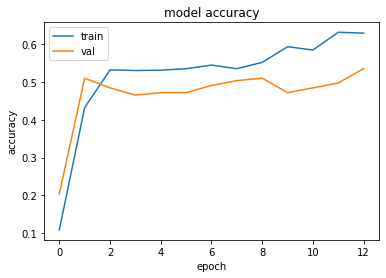

In [ ]:
from matplotlib import pyplot as plt
def plot_lines(history,train_key,val_key,title,y_tag):
  plt.plot(history.history[train_key])
  plt.plot(history.history[val_key])
  plt.title(title)
  plt.ylabel(y_tag)
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

plot_lines(history,'accuracy','val_accuracy','model accuracy','accuracy')

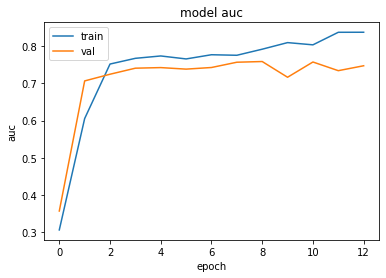

In [ ]:
plot_lines(history,'auc','val_auc','model auc','auc')

In [ ]:
evals = model.evaluate(X_test, y_test)

5/5 [==============================] - 31s 6s/step - loss: 0.7574 - accuracy: 0.5316 - auc: 0.7554


In [ ]:
model.load_weights('sent-model-2')

In [ ]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 30s 6s/step - loss: 0.7004 - accuracy: 0.5253 - auc: 0.7774


[0.7003724575042725, 0.5253164768218994, 0.7773894667625427]